#### Experiments Reproduction

In [ ]:
# Libraries importation
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm_notebook as tqdm

import torch.nn.functional as F
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from numpy import linalg as LA

import pandas as pd
from sklearn import preprocessing

import seaborn as sns
sns.set()

In [ ]:
use_gpu = False # set it to True to use GPU and False to use CPU
if use_gpu:
    torch.cuda.set_device(0)

#### System Parameters as used in the paper

Mini batch size: 128  
Missing rate: 0.2  
Hint rate: 0.9  
Loss Hyperparameters: 10  
Train Rate: 0.8  
Learning Rate: 0.001  
Epochs: 10000   

In [ ]:
# Initialize System Parameters
def init_params(mb_size=128, p_miss=0.2, p_hint=0.9, alpha=10, train_rate=0.8, learning_rate=0.001, epochs=10000): 
    # Mini batch size
    mb_size = mb_size
    # Missing rate
    p_miss = p_miss
    # Hint rate
    p_hint = p_hint
    # Loss Hyperparameters
    alpha = alpha
    # Train Rate
    train_rate = train_rate
    # Learning Rate
    learning_rate = learning_rate
    # Epochs
    epochs = epochs
    
    return mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs

In [ ]:
mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs = init_params()

#### GAIN Architecture   
- Generator
- Discriminator
- Hint Vector

In [ ]:
# Discriminator
class NetD(torch.nn.Module):
    def __init__(self, Dim, H_Dim1, H_Dim2):
        super(NetD, self).__init__()
        
        self.fc0 = torch.nn.Linear(Dim * 1, H_Dim1) # without Hint 
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1) # with Hint
        
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc0, self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, h, hint): 
        if hint == False:
            inp = x # Data without Hint
            out = self.relu(self.fc0(inp))
        else: 
            inp = torch.cat((x, h), dim=1)  # Hint + Data Concatenate
            out = self.relu(self.fc1(inp))
        
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
        return out

    
# Generator
class NetG(torch.nn.Module):
    def __init__(self, Dim, H_Dim1, H_Dim2):
        super(NetG, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, m): 
        inp = torch.cat((x, m), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
        return out

#### GAIN Functions

In [ ]:
# Hint Vector Generation
def sample_M(m, n, p):                         # e.g. m=mb_size , n=Dim, p=1-p_hint =0.1
    A = np.random.uniform(0., 1., size=[m, n]) # size of mb_size X Dim -> values between 0 to 1
    B = A > p                                  # if A value bigger than 0.1 then True and C=1 else False and C=0
    C = 1. * B
    return C                                   # C is shape mb_size X Dim


# Random sample generator for Z
def sample_Z(m, n):
    return np.random.uniform(0., 0.01, size = [m, n])   


# Mini-batch generation
def sample_idx(m, n):              
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

In [ ]:
def discriminator_loss(netG, netD, M, X, H, hint): 
    # Generator
    G_sample = netG(X, M)
    # Combine with original data
    Hat_New_X = X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H, hint)
    # Loss
    D_loss = -torch.mean(M * torch.log(D_prob + 1e-8) + (1-M) * torch.log(1. - D_prob + 1e-8))
    return D_loss


def generator_loss(netG, netD, X, M, New_X, H, Lg, Lm, hint, alpha=alpha):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)
    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H, hint)

    # Loss
    G_loss1 = -torch.mean((1-M) * torch.log(D_prob + 1e-8))
    # MSE loss finds the difference between New_X and Generators Sample only on the real values
    # Because i want the real values to be as close as they can be to the New_X. I care only for the imputed values
    MSE_train_loss = torch.mean((M * New_X - M * G_sample)**2) / torch.mean(M)
    
    # G_loss = G_loss1 + alpha * MSE_train_loss 
    if Lm == False:
        G_loss = G_loss1 
    elif Lg == False:
        G_loss = alpha * MSE_train_loss
    elif (Lm == True) and (Lg == True):
        G_loss = G_loss1 + alpha * MSE_train_loss

    # MSE Performance metric
    # The difference between real data , X and the Imputed Data
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return G_loss, MSE_train_loss, MSE_test_loss


def test_loss(netG, netD, X, M, New_X):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)

    # MSE Performance metric
    # The difference between real data , X and the Imputed Data
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return MSE_test_loss, G_sample

In [ ]:
def initializations(dataset_file, size=False, lnth=0, impute=False): 
    # Data generation
    Data = np.loadtxt(dataset_file, delimiter=",", skiprows=1)
    # Shuffle Data
    np.random.seed(1234)
    np.random.shuffle(Data)
    
    if size==True:
        Data = Data[:lnth] # for data set size vs rmse plot
    
    if impute==True:
        Data_y = Data[:,Data.shape[1]-1]
        Data = Data[:,:Data.shape[1]-1]
    
    # Parameters
    No = len(Data)
    Dim = len(Data[0,:])

    # Hidden state dimensions
    H_Dim1 = Dim
    H_Dim2 = Dim

    # Normalization (0 to 1)
    # z = (x-min) / (X_max + ε)
    # ε is used to avoid division by zero
    Min_Val = np.zeros(Dim)
    Max_Val = np.zeros(Dim)

    for i in range(Dim):
        Min_Val[i] = np.min(Data[:,i])
        Data[:,i] = Data[:,i] - np.min(Data[:,i])
        Max_Val[i] = np.max(Data[:,i])
        Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)    
    
    # %% Missing introducing
    p_miss_vec = p_miss * np.ones((Dim,1)) # p_miss ... Dim x 1 size, Dim is number of columns of dataset 

    Missing = np.zeros((No,Dim))           # zero ... Size of dataset No, Dim , No is the rows
    # Mask Vector Generation
    for i in range(Dim):
        A = np.random.uniform(0., 1., size = [len(Data),]) # A is size No x 1
        B = A > p_miss_vec[i]       # B is size No x 1, If a value is False, it is a missing data point
        Missing[:,i] = 1.*B         # No x Dim, 1 * False = 0 and 1 * True = 1
    
    # %% Train Test Division
    idx = np.random.permutation(No) # number of No values. permutation of numbers from 0 - No
    Train_No = int(No * train_rate) # No.of Rows * train_rate
    Test_No = No - Train_No         # 1 - Train_No 
    
    if impute==False:
        return Data, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No
    else:
        return Data, Data_y, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No

In [ ]:
def trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, cv=True, Lg=True, Lm=True, hint=True, 
              alpha=alpha, epochs=epochs, printLoss=False):
    # %% Training
    # %% Start Iterations
    for it in tqdm(range(epochs)):
        # %% Inputs
        if cv == False:
            mb_idx = sample_idx(Train_No, mb_size)    # choose indexes
            X_mb = trainX[mb_idx,:]  

            Z_mb = sample_Z(mb_size, Dim)             # uniform 0 to 0.01
            M_mb = trainM[mb_idx, :]                  # mini batch for Missing, 1 and 0 matrix
            H_mb1 = sample_M(mb_size, Dim, 1-p_hint)  # random 0 or 1 with 1 if prob > 0.1
            H_mb = M_mb * H_mb1 # Hint vector final -> 0 on all Missing values and also to some known
                                # because of a small probability that H_mb1 having 0 values, 
                                # but most known data points are 1
            
            New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce 
        else:
            mb_idx = sample_idx(len(trainX), mb_size)
            X_mb = trainX[mb_idx, :]
            
            Z_mb = sample_Z(mb_size, Dim)
            M_mb = trainM[mb_idx, :] 
            H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
            H_mb = M_mb * H_mb1
            
            New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb 
        
        if use_gpu is True:
            X_mb = torch.tensor(X_mb, device='cuda').float()
            M_mb = torch.tensor(M_mb, device='cuda').float()
            H_mb = torch.tensor(H_mb, device='cuda').float()
            New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
        else:
            X_mb = torch.tensor(X_mb).float()
            M_mb = torch.tensor(M_mb).float()
            H_mb = torch.tensor(H_mb).float()
            New_X_mb = torch.tensor(New_X_mb).float()

        # Train D
        optimD.zero_grad() 
        D_loss = discriminator_loss(netG, netD, M=M_mb, X=New_X_mb, H=H_mb, hint=hint)
        D_loss.backward()
        optimD.step()

        # Train G
        optimG.zero_grad() 
        G_loss, G_mse_loss, G_mse_test = generator_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb, H=H_mb, 
                                                        Lg=Lg, Lm=Lm, hint=hint, alpha=alpha)
        G_loss.backward()
        optimG.step()
        
        # %% Intermediate Losses
        if printLoss==True:
            if it % 100 == 0:
                print('Iter: {}'.format(it),end='\t')
                print('Train_loss: {:.4}'.format(G_mse_loss),end='\t')
                print('Test_loss: {:.4}'.format(G_mse_test),end='\t')
                print('D_loss: {:.4}'.format(D_loss))


def testGAIN(netG, netD, Dim, testM, testX, cv=True, impute=False):
    if cv == False:
        Z_mb = sample_Z(Test_No, Dim) 
    else:
        Z_mb = sample_Z(len(testM), Dim) 
        
    M_mb = testM # all test samples together
    X_mb = testX

    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

    # make the tensors
    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device='cuda').float()
        M_mb = torch.tensor(M_mb, device='cuda').float()
        New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
    else:
        X_mb = torch.tensor(X_mb).float()
        M_mb = torch.tensor(M_mb).float()
        New_X_mb = torch.tensor(New_X_mb).float()

    MSE_final, Sample = test_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb)

    """print('Final Test RMSE: ' + str(np.sqrt(MSE_final.item())))
    print()"""
    
    if impute==False:
        return np.sqrt(MSE_final.item())
    else:
        return Sample

In [ ]:
def experiment(dataset_file, Lg=True, Lm=True, hint=True, alpha=alpha, epochs=epochs, 
               learning_rate=learning_rate, size=False, lnth=0, impute=False, printLoss=False): 
    # %% Initializations    
    if impute==False:
        if size==False:
            Data, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No = initializations(dataset_file)
        else:
            Data, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No = initializations(dataset_file, size=size, lnth=lnth)           
    else:
        Data, Data_y, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No = initializations(dataset_file, impute=impute)
    
    # %% Cross Validation
    kf = KFold(n_splits=5)
    experiment_rmse_mean =[]
    experiment_rmse_std=[]
    auroc_mean = []
    
    for i in range(10): # Number of experiments
        if impute==False:  
            rmse_cv_scores=[]
            for train_index, test_index in kf.split(Data):

                # Train / Test Features
                trainX, testX = Data[train_index], Data[test_index]
                # Train / Test Missing Indicators
                trainM, testM = Missing[train_index], Missing[test_index]

                if impute==True:
                    trainY, testY = Data_y[train_index], Data_y[test_index]

                # %% Init Network 
                if use_gpu is True:
                    netD = NetD(Dim, H_Dim1, H_Dim2).cuda()
                    netG = NetG(Dim, H_Dim1, H_Dim2).cuda()
                else:
                    netD = NetD(Dim, H_Dim1, H_Dim2)
                    netG = NetG(Dim, H_Dim1, H_Dim2)
                    
                # Optimizers
                optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate) # discriminator optimizer
                optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate) # generator optimizer

                # %% Training
                trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, Lg=Lg, Lm=Lm, hint=hint, 
                          alpha=alpha, epochs=epochs, printLoss=printLoss)

                # %% Testing
                if impute==False:
                    rmse_cv_scores.append(testGAIN(netG, netD, Dim, testM, testX))
                else:
                    # Impute train and test and then fit on logistic
                    trainX = testGAIN(netG, netD, Dim, trainX, trainM, impute=impute)
                    testX  = testGAIN(netG, netD, Dim, testX, testM, impute=impute)

                    # Train a logistic Regression
                    clf = LogisticRegression(random_state=0,solver='lbfgs', 
                                             max_iter=2000).fit(trainX.detach().numpy(),trainY)
                    preds = clf.predict(testX.detach().numpy())

                    # print("roc_auc_score: {}".format(roc_auc_score(testY, preds)))
                    fpr, tpr, thresholds = roc_curve(testY, preds)
                    auroc_scores.append(auc(fpr, tpr))
                    
            # %% Calculate avg_RMSE on test
            mean = sum(rmse_cv_scores) / len(rmse_cv_scores)
            print("Average RMSE score: {}".format(mean))

            # %% Calculate the std on test
            variance = sum((rmse - mean) ** 2 for rmse in rmse_cv_scores) / len(rmse_cv_scores) 
            std = np.sqrt(variance)
            print("Standard Deviation of RMSE score: {}".format(std))

            experiment_rmse_mean.append(mean)
            experiment_rmse_std.append(std)
        else:
            auroc_scores=[]
            for train_index, test_index in kf.split(Data, Data_y):
                trainX, testX = Data[train_index], Data[test_index]
                trainM, testM = Missing[train_index], Missing[test_index]
                trainY, testY = Data_y[train_index] , Data_y[test_index]

                if use_gpu is True:
                    netD = NetD(Dim, H_Dim1, H_Dim2).cuda()
                    netG = NetG(Dim, H_Dim1, H_Dim2).cuda()
                else:
                    netD = NetD(Dim, H_Dim1, H_Dim2)
                    netG = NetG(Dim, H_Dim1, H_Dim2)

                optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate) # discriminator optimizer
                optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate) # generator optimizer

                trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, Lg=Lg, Lm=Lm, hint=hint, 
                          alpha=alpha, epochs=epochs, printLoss=printLoss)

                # Impute train and test and then fit on logistic
                trainX = testGAIN(netG, netD, Dim, trainX, trainM, impute=impute)
                testX  = testGAIN(netG, netD, Dim, testX, testM, impute=impute)

                # Train a logistic Regression
                clf = LogisticRegression(random_state=0,solver='lbfgs', 
                                         max_iter=2000).fit(trainX.detach().numpy(),trainY)
                preds = clf.predict(testX.detach().numpy())

                # print("roc_auc_score: {}".format(roc_auc_score(testY, preds)))
                fpr, tpr, thresholds = roc_curve(testY, preds)
                auroc_scores.append(auc(fpr, tpr))
                
            auroc_mean.append(np.mean(auroc_scores))
    
    if impute==False:
        total_avg = sum(experiment_rmse_mean) / len(experiment_rmse_mean)
        total_std = np.sqrt(sum((rmse - total_avg )**2 for rmse in experiment_rmse_mean)/len(experiment_rmse_mean))
        print("Total average: {}".format(total_avg))
        print("Total std: {}".format(total_std))
        return total_avg, total_std
    else:
        return auroc_mean

### Gain_Loss_Functions 

#### Datasets (without labels)

In [ ]:
#%% Data (without labels)
dataset_file_list = ['unlabeled-data/breast.csv', 'unlabeled-data/Spam.csv', 'unlabeled-data/Letter.csv', 
                     'unlabeled-data/credit.csv', 'unlabeled-data/OnlineNewsPopularity.csv']

### Experiments 

#### 1. RMSE without Cross Validation

Using all loss functions

In [ ]:
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    # %% Initializations    
    Data, No, Dim, H_Dim1, H_Dim2, Min_Val, Max_Val, p_miss_vec, Missing, idx, Train_No, Test_No = initializations(dataset_file)
    
    # Train / Test Features
    trainX = Data[idx[:Train_No],:]
    testX = Data[idx[Train_No:],:]
    
    # Train / Test Missing Indicators
    trainM = Missing[idx[:Train_No],:]
    testM = Missing[idx[Train_No:],:]
    
    # %% Init Network 
    if use_gpu is True:
        netD = NetD(Dim, H_Dim1, H_Dim2).cuda()
        netG = NetG(Dim, H_Dim1, H_Dim2).cuda()
    else:
        netD = NetD(Dim, H_Dim1, H_Dim2)
        netG = NetG(Dim, H_Dim1, H_Dim2)
  
    # Optimizers
    optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate) # discriminator optimizer
    optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate) # generator optimizer
    
    # %% Training
    trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, cv=False, Lg=True, Lm=True, hint=True, 
              alpha=alpha, epochs=epochs)

    # %% Testing
    rmse_score = testGAIN(netG, netD, Dim, testM, testX, cv=False)
    print('Final Test RMSE: ' + str(rmse_score))
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

Final Test RMSE: 0.09501876693527964
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

Final Test RMSE: 0.0511893326340449
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

Final Test RMSE: 0.14710095024396797
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

Final Test RMSE: 0.1408389371494415
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

Final Test RMSE: 0.20769229653554055
-------------------------------------



#### 2. With 5-Cross Validations per experiment
### Reporting RMSE avg +/- std 10 times on 5 Fold Cross Validation

Using all loss functions

In [ ]:
total_avg_list_1 = []
total_std_list_1 = []
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    total_avg, total_std = experiment(dataset_file, Lg=True, Lm=True, hint=True, 
                                      epochs=epochs, learning_rate=learning_rate, printLoss=False)
    total_avg_list_1.append(total_avg)
    total_std_list_1.append(total_std)
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11516085586962171
Standard Deviation of RMSE score: 0.00022431921462347237


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11745334005368757
Standard Deviation of RMSE score: 0.002764204942654565
Total average: 0.11630709796165464
Total std: 0.0011462420920329286
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.05770528522898354
Standard Deviation of RMSE score: 0.0007600568596320828


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.057509118820255944
Standard Deviation of RMSE score: 0.00025919354591907515
Total average: 0.05760720202461975
Total std: 9.8083204363799e-05
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13506131027597423
Standard Deviation of RMSE score: 0.005052179428693543


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.12844578378624394
Standard Deviation of RMSE score: 0.0026205101695164768
Total average: 0.1317535470311091
Total std: 0.0033077632448651473
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.15052378930145485
Standard Deviation of RMSE score: 0.012808552537027479


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.14425583633899225
Standard Deviation of RMSE score: 0.004294424190526919
Total average: 0.14738981282022356
Total std: 0.0031339764812313015
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.2049331084181844
Standard Deviation of RMSE score: 0.005623107074909886


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.20834642114958796
Standard Deviation of RMSE score: 0.002114462639059872
Total average: 0.20663976478388618
Total std: 0.0017066563657017753
-------------------------------------



In [ ]:
print(total_avg_list_1)
print(total_std_list_1)

[0.11630709796165464, 0.05760720202461975, 0.1317535470311091, 0.14738981282022356, 0.20663976478388618]
[0.0011462420920329286, 9.8083204363799e-05, 0.0033077632448651473, 0.0031339764812313015, 0.0017066563657017753]


Without Lg (generator's loss ) = cross_entropy(discriminator's output and mask) 

We use only the below equation to Update Generator:

    alpha*mse(x_missing_data,x_imputed)

In [ ]:
total_avg_list_2 = []
total_std_list_2 = []
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    total_avg, total_std = experiment(dataset_file, Lg=False, Lm=True, hint=True, 
                                      epochs=epochs, learning_rate=learning_rate, printLoss=False)
    total_avg_list_2.append(total_avg)
    total_std_list_2.append(total_std)
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.10133659294316631
Standard Deviation of RMSE score: 0.008176683317533823


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11047834612368926
Standard Deviation of RMSE score: 0.0034501453145132435
Total average: 0.10590746953342778
Total std: 0.004570876590261473
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.05300324266593075
Standard Deviation of RMSE score: 0.00036383272996142607


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.05288045917642668
Standard Deviation of RMSE score: 0.0003949423745185504
Total average: 0.052941850921178715
Total std: 6.139174475203527e-05
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.14588608559850985
Standard Deviation of RMSE score: 0.008936244443748617


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13661320129007234
Standard Deviation of RMSE score: 0.00047107347576585967
Total average: 0.14124964344429108
Total std: 0.004636442154218753
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.18576678573979652
Standard Deviation of RMSE score: 0.002256379414048243


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.18839893636724442
Standard Deviation of RMSE score: 0.0009350205177242193
Total average: 0.18708286105352046
Total std: 0.0013160753137239495
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.24395011416688184
Standard Deviation of RMSE score: 0.0016585322129683278


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.24530974595565885
Standard Deviation of RMSE score: 0.0021024540626146115
Total average: 0.24462993006127035
Total std: 0.000679815894388508
-------------------------------------



In [ ]:
print("breast | spam | letter | credit | news")
print(total_avg_list_2)
print(total_std_list_2)

breast | spam | letter | credit | news
[0.10590746953342778, 0.052941850921178715, 0.14124964344429108, 0.18708286105352046, 0.24462993006127035]
[0.004570876590261473, 6.139174475203527e-05, 0.004636442154218753, 0.0013160753137239495, 0.000679815894388508]


Without Lm = alpha*mse(x_missing_data,x_imputed)

In [ ]:
total_avg_list_3 = []
total_std_list_3 = []
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    total_avg, total_std = experiment(dataset_file, Lg=True, Lm=False, hint=True, 
                                      epochs=epochs, learning_rate=learning_rate, printLoss=False)
    total_avg_list_3.append(total_avg)
    total_std_list_3.append(total_std)
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.5174308425988603
Standard Deviation of RMSE score: 0.016923357972986552


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.44306218080438
Standard Deviation of RMSE score: 0.11165040966509923
Total average: 0.48024651170162014
Total std: 0.03718433089724016
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.3388998642351343
Standard Deviation of RMSE score: 0.013794742310680952


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.3954178494281919
Standard Deviation of RMSE score: 0.25066370172824315
Total average: 0.3671588568316631
Total std: 0.02825899259652881
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.5292128117463897
Standard Deviation of RMSE score: 0.022025309019926997


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.5050156935555027
Standard Deviation of RMSE score: 0.04294789127437115
Total average: 0.5171142526509462
Total std: 0.012098559095443495
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.3663441517928913
Standard Deviation of RMSE score: 0.09664633668187039


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.43304986335534
Standard Deviation of RMSE score: 0.02406013542645205
Total average: 0.39969700757411564
Total std: 0.03335285578122435
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.4001776428332958
Standard Deviation of RMSE score: 0.0074772577939027085


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.37437036569939913
Standard Deviation of RMSE score: 0.019360723847196504
Total average: 0.3872740042663475
Total std: 0.012903638566948344
-------------------------------------



In [ ]:
print("breast | spam | letter | credit | news")
print(total_avg_list_3)
print(total_std_list_3)

breast | spam | letter | credit | news
[0.48024651170162014, 0.3671588568316631, 0.5171142526509462, 0.39969700757411564, 0.3872740042663475]
[0.03718433089724016, 0.02825899259652881, 0.012098559095443495, 0.03335285578122435, 0.012903638566948344]


Without Hint Vector

In [ ]:
total_avg_list_4 = []
total_std_list_4 = []
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    total_avg, total_std = experiment(dataset_file, Lg=True, Lm=True, hint=False, 
                                      epochs=epochs, learning_rate=learning_rate, printLoss=False)
    total_avg_list_4.append(total_avg)
    total_std_list_4.append(total_std)
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13348526534982308
Standard Deviation of RMSE score: 0.005220897390509419


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13372043959095942
Standard Deviation of RMSE score: 0.00107549225887478
Total average: 0.13360285247039125
Total std: 0.00011758712056816889
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.05851028521467509
Standard Deviation of RMSE score: 0.0004675223299442366


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.059834102967539916
Standard Deviation of RMSE score: 0.0011615946505749916
Total average: 0.05917219409110751
Total std: 0.000661908876432412
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.1382309136986411
Standard Deviation of RMSE score: 0.003081904099786467


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13396719197226314
Standard Deviation of RMSE score: 0.0012844901670011483
Total average: 0.13609905283545212
Total std: 0.002131860863188978
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.18601637209556487
Standard Deviation of RMSE score: 0.0010562921995043856


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.186818785678504
Standard Deviation of RMSE score: 0.0011909061984417546
Total average: 0.18641757888703442
Total std: 0.00040120679146955773
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.20502642419116313
Standard Deviation of RMSE score: 0.007334401071455041


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.2097495095214425
Standard Deviation of RMSE score: 0.0003262278532057822
Total average: 0.2073879668563028
Total std: 0.0023615426651396876
-------------------------------------



In [ ]:
print("breast | spam | letter | credit | news")
print(total_avg_list_4)
print(total_std_list_4)

breast | spam | letter | credit | news
[0.13360285247039125, 0.05917219409110751, 0.13609905283545212, 0.18641757888703442, 0.2073879668563028]
[0.00011758712056816889, 0.000661908876432412, 0.002131860863188978, 0.00040120679146955773, 0.0023615426651396876]


Without Hint and Lm loss

In [ ]:
total_avg_list_5 = []
total_std_list_5 = []
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    total_avg, total_std = experiment(dataset_file, Lg=True, Lm=False, hint=False, 
                                      epochs=epochs, learning_rate=learning_rate, printLoss=False)
    total_avg_list_5.append(total_avg)
    total_std_list_5.append(total_std)
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.29187533864690685
Standard Deviation of RMSE score: 0.0047359536684415116


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.2884777227014047
Standard Deviation of RMSE score: 0.02233722900245247
Total average: 0.2901765306741558
Total std: 0.0016988079727510708
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.15308444347281178
Standard Deviation of RMSE score: 0.08163848477144008


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.06460450974331113
Standard Deviation of RMSE score: 0.004286149875339051
Total average: 0.10884447660806146
Total std: 0.044239966864750326
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.21978036997584946
Standard Deviation of RMSE score: 0.03692754744844165


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.1958156599925761
Standard Deviation of RMSE score: 0.0005573648256771285
Total average: 0.2077980149842128
Total std: 0.011982354991636676
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.18009037250487006
Standard Deviation of RMSE score: 0.012126923243431537


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.16414849098140655
Standard Deviation of RMSE score: 0.004457717336576128
Total average: 0.17211943174313832
Total std: 0.007970940761731757
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.23536670633936035
Standard Deviation of RMSE score: 0.01729062125723896


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.3064796355065205
Standard Deviation of RMSE score: 0.08923916295697155
Total average: 0.27092317092294044
Total std: 0.03555646458358008
-------------------------------------



In [ ]:
print("breast | spam | letter | credit | news")
print(total_avg_list_5)
print(total_std_list_5)

breast | spam | letter | credit | news
[0.2901765306741558, 0.10884447660806146, 0.2077980149842128, 0.17211943174313832, 0.27092317092294044]
[0.0016988079727510708, 0.044239966864750326, 0.011982354991636676, 0.007970940761731757, 0.03555646458358008]


#### 3. Varying the settings

### Plotting Missing Data rate,  number of samples, number of features and learning rate impacts on RMSE

In [ ]:
if not os.path.exists('plots/'):
    os.makedirs('plots/')

### a) Missing rate:

In [ ]:
# Reset System Parameters
mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs = init_params()

In [ ]:
missing_rates = [0.2, 0.4, 0.6, 0.8]

total_6 = []
for dataset_file in dataset_file_list:
    print('Dataset: {}'.format(str(dataset_file)))
    total_avg_list_6 = []
    for mr in missing_rates:
        # Missing rate
        p_miss = mr
        total_avg, total_std = experiment(dataset_file, Lg=True, Lm=True, hint=True, 
                                          epochs=epochs, learning_rate=learning_rate, printLoss=False)
        total_avg_list_6.append(total_avg)
    total_6.append(total_avg_list_6)
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11579422237463864
Standard Deviation of RMSE score: 0.012873496726988079


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11200484442475564
Standard Deviation of RMSE score: 9.337767992667612e-05
Total average: 0.11389953339969713
Total std: 0.001894688974941501


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13970031196062774
Standard Deviation of RMSE score: 0.0069365143788557015


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.1419448754590507
Standard Deviation of RMSE score: 0.0015610041640857775
Total average: 0.14082259370983924
Total std: 0.0011222817492114873


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.2011456164613704
Standard Deviation of RMSE score: 0.00561335141372761


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.19987233322841064
Standard Deviation of RMSE score: 0.0017594648034428007
Total average: 0.20050897484489053
Total std: 0.0006366416164798883


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.2912336056277861
Standard Deviation of RMSE score: 0.00542712932847858


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.3421221245025289
Standard Deviation of RMSE score: 0.015221029823740101
Total average: 0.3166778650651575
Total std: 0.025444259437371386
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.05780981124446499
Standard Deviation of RMSE score: 0.00041446084203886416


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.058422771692023825
Standard Deviation of RMSE score: 0.0009561604373576095
Total average: 0.05811629146824441
Total std: 0.00030648022377941647


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.06456898827211234
Standard Deviation of RMSE score: 0.002572763033331312


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.060098605726803395
Standard Deviation of RMSE score: 0.00013982366269249188
Total average: 0.06233379699945787
Total std: 0.002235191272654473


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.09655039578422324
Standard Deviation of RMSE score: 0.021640989084709947


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.09495521709641412
Standard Deviation of RMSE score: 0.029776964273527412
Total average: 0.09575280644031868
Total std: 0.0007975893439045589


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11760269570144646
Standard Deviation of RMSE score: 0.05672349278204927


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.11195053782304662
Standard Deviation of RMSE score: 0.047383195928217416
Total average: 0.11477661676224654
Total std: 0.002826078939199922
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13594575337261736
Standard Deviation of RMSE score: 0.009327862019972516


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.13355917874458317
Standard Deviation of RMSE score: 3.226457060646892e-05
Total average: 0.13475246605860025
Total std: 0.0011932873140170913


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.1545480395844445
Standard Deviation of RMSE score: 0.010798862908352053


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.14393217340295827
Standard Deviation of RMSE score: 0.002312123982136857
Total average: 0.1492401064937014
Total std: 0.005307933090743108


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.20638532058890258
Standard Deviation of RMSE score: 0.05101135996810467


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.1908354594366959
Standard Deviation of RMSE score: 0.005535971854874991
Total average: 0.19861039001279923
Total std: 0.007774930576103345


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.22856954476994445
Standard Deviation of RMSE score: 0.009699916898546365


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.20327066224209261
Standard Deviation of RMSE score: 0.00040513568338894357
Total average: 0.21592010350601853
Total std: 0.01264944126392592
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.15045063878226378
Standard Deviation of RMSE score: 0.006999244773604876


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.14286242967314888
Standard Deviation of RMSE score: 0.0028617636141153174
Total average: 0.14665653422770633
Total std: 0.003794104554557448


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.15792192365282703
Standard Deviation of RMSE score: 0.010896188061261552


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.16760809430022755
Standard Deviation of RMSE score: 0.016553289833979898
Total average: 0.1627650089765273
Total std: 0.004843085323700258


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.23864382270847917
Standard Deviation of RMSE score: 0.009562017159614689


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.20468565975651604
Standard Deviation of RMSE score: 0.034033682276874117
Total average: 0.2216647412324976
Total std: 0.016979081475981567


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.21924316383510983
Standard Deviation of RMSE score: 0.007229072641337292


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.27256425103520776
Standard Deviation of RMSE score: 0.010568569575642062
Total average: 0.2459037074351588
Total std: 0.026660543600048964
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.21029530640828212
Standard Deviation of RMSE score: 0.0007033170255835719


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.21043574481414734
Standard Deviation of RMSE score: 0.00143178030099117
Total average: 0.21036552561121474
Total std: 7.021920293261152e-05


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.2368797895743511
Standard Deviation of RMSE score: 0.005898306844677709


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.23089190780912866
Standard Deviation of RMSE score: 0.004955620495674287
Total average: 0.2338858486917399
Total std: 0.0029939408826112207


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.31677052554159274
Standard Deviation of RMSE score: 0.008357169288130462


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.3051584327775779
Standard Deviation of RMSE score: 3.30341044678939e-05
Total average: 0.31096447915958536
Total std: 0.005806046382007407


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.30037876599819924
Standard Deviation of RMSE score: 0.016277506911818423


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average RMSE score: 0.351731922621525
Standard Deviation of RMSE score: 0.005694892689971448
Total average: 0.3260553443098621
Total std: 0.025676578311662868
-------------------------------------



In [ ]:
print("breast | spam | letter | credit | news")
print(total_6)

breast | spam | letter | credit | news
[[0.11389953339969713, 0.14082259370983924, 0.20050897484489053, 0.3166778650651575], [0.05811629146824441, 0.06233379699945787, 0.09575280644031868, 0.11477661676224654], [0.13475246605860025, 0.1492401064937014, 0.19861039001279923, 0.21592010350601853], [0.14665653422770633, 0.1627650089765273, 0.2216647412324976, 0.2459037074351588], [0.21036552561121474, 0.2338858486917399, 0.31096447915958536, 0.3260553443098621]]


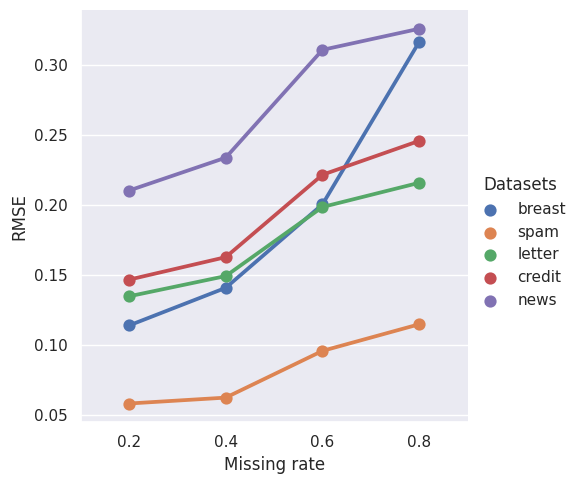

In [ ]:
df = pd.DataFrame(list(zip(missing_rates, total_6[0], total_6[1], 
                           total_6[2], total_6[3], total_6[4])), 
                  columns =['Missing rate', 'breast', 'spam', 'letter', 'credit', 'news'])

df = df.melt('Missing rate', var_name='Datasets', value_name='RMSE')
# g = sns.catplot(x='Missing rate %', y="RMSE", hue='Datasets', data=df, kind='point')
sns.catplot(x='Missing rate', y="RMSE", hue='Datasets', data=df, kind='point').savefig("plots/missing_rate.png")

### b) Dataset size:

In [ ]:
# Reset System Parameters
mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs = init_params()

In [ ]:
total_7 = []
data_sizes = [0.1, 0.3, 0.5, 0.7]
for dataset_file in dataset_file_list:
    total_avg_list_7 = []
    print('Dataset: {}'.format(str(dataset_file)))
    
    if (str(dataset_file)=='unlabeled-data/breast.csv'): ########
        mb_size = 28
    else:
        mb_size = 128
        
    Data_full = np.loadtxt(dataset_file, delimiter=",",skiprows=1)
    data_size = [int(data_sizes[0]*len(Data_full)),int(data_sizes[1]*len(Data_full)),
                 int(data_sizes[2]*len(Data_full)),int(data_sizes[3]*len(Data_full))]
    for lnth in data_size:
        total_avg, total_std = experiment(dataset_file, Lg=True, Lm=True, hint=True, epochs=epochs, 
                                          learning_rate=learning_rate, size=True, lnth=lnth, printLoss=False)
        total_avg_list_7.append(total_avg)
    total_7.append(total_avg_list_7)
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.30393005339777046
Standard Deviation of RMSE score: 0.004762886933569188


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.343524138702873
Standard Deviation of RMSE score: 0.002521622006191243
Total average: 0.32372709605032174
Total std: 0.019797042652551278


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.16719442405829024
Standard Deviation of RMSE score: 0.006972477046500336


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1817642657421909
Standard Deviation of RMSE score: 0.015769056237691745
Total average: 0.17447934490024058
Total std: 0.007284920841950329


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1180065793789783
Standard Deviation of RMSE score: 0.0008556147742361034


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.11074401839121237
Standard Deviation of RMSE score: 0.0014537195858809748
Total average: 0.11437529888509533
Total std: 0.003631280493882963


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09387288512748446
Standard Deviation of RMSE score: 0.0013245267946943098


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09609056984717018
Standard Deviation of RMSE score: 0.000589633020910002
Total average: 0.09498172748732732
Total std: 0.0011088423598428626
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1458240235778917
Standard Deviation of RMSE score: 0.0008110879224769024


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.15155308968391856
Standard Deviation of RMSE score: 0.003971836200852674
Total average: 0.14868855663090513
Total std: 0.0028645330530134294


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.08787389844543833
Standard Deviation of RMSE score: 8.485342627247844e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.0863758833987946
Standard Deviation of RMSE score: 0.0006605597251317583
Total average: 0.08712489092211646
Total std: 0.0007490075233218679


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.07104085093828483
Standard Deviation of RMSE score: 0.002525608675933981


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.07156285348453337
Standard Deviation of RMSE score: 0.0004906833791390522
Total average: 0.0713018522114091
Total std: 0.00026100127312427


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06023866016225721
Standard Deviation of RMSE score: 0.0016947966446512405


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.05984787777400785
Standard Deviation of RMSE score: 9.09686214959314e-05
Total average: 0.06004326896813253
Total std: 0.00019539119412467776
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1372604898269963
Standard Deviation of RMSE score: 0.0008568700271286561


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13891008475262387
Standard Deviation of RMSE score: 0.0007351248893082696
Total average: 0.13808528728981007
Total std: 0.0008247974628137894


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.12671322427969095
Standard Deviation of RMSE score: 0.0006681045974094302


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.12888455810938623
Standard Deviation of RMSE score: 0.0028457264554127004
Total average: 0.12779889119453858
Total std: 0.001085666914847641


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.12848136284069872
Standard Deviation of RMSE score: 0.0019726135079479318


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13038476262693116
Standard Deviation of RMSE score: 2.9378661066045697e-05
Total average: 0.12943306273381494
Total std: 0.0009516998931162202


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.12975770169176132
Standard Deviation of RMSE score: 0.0036645565496251503


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.12861520388117764
Standard Deviation of RMSE score: 0.00241833564136211
Total average: 0.12918645278646948
Total std: 0.0005712489052918379
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.14474112346211704
Standard Deviation of RMSE score: 0.0033451909085632364


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1440591020324029
Standard Deviation of RMSE score: 0.0009342634283372592
Total average: 0.14440011274725997
Total std: 0.00034101071485706513


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13613948139480872
Standard Deviation of RMSE score: 0.0004685294167373899


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13661966935732933
Standard Deviation of RMSE score: 0.00016898753358161878
Total average: 0.13637957537606904
Total std: 0.0002400939812603059


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13636735494467667
Standard Deviation of RMSE score: 0.00017115441633304418


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13458385840357012
Standard Deviation of RMSE score: 0.0020521898318288795
Total average: 0.1354756066741234
Total std: 0.000891748270553272


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13181545692422503
Standard Deviation of RMSE score: 0.0011057805453758285


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13275644759853217
Standard Deviation of RMSE score: 0.003628189883084401
Total average: 0.1322859522613786
Total std: 0.0004704953371535703
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.2031871365753396
Standard Deviation of RMSE score: 0.00038287939845299546


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.2026452772436122
Standard Deviation of RMSE score: 0.0010516905974004287
Total average: 0.2029162069094759
Total std: 0.0002709296658637006


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19740059562093673
Standard Deviation of RMSE score: 0.001030188746204419


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.20172898340244705
Standard Deviation of RMSE score: 0.0016576683562209565
Total average: 0.19956478951169188
Total std: 0.002164193890755159


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.20043169567413782
Standard Deviation of RMSE score: 0.0009411375726701421


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19803533987702587
Standard Deviation of RMSE score: 0.00021057772289255483
Total average: 0.19923351777558185
Total std: 0.0011981778985559743


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1984789016404632
Standard Deviation of RMSE score: 0.0012916729164074159


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1958773135109022
Standard Deviation of RMSE score: 0.0010683350247654017
Total average: 0.19717810757568272
Total std: 0.0013007940647804944
-------------------------------------



In [ ]:
print("breast | spam | letter | credit | news")
print(total_7)

breast | spam | letter | credit | news
[[0.32372709605032174, 0.17447934490024058, 0.11437529888509533, 0.09498172748732732], [0.14868855663090513, 0.08712489092211646, 0.0713018522114091, 0.06004326896813253], [0.13808528728981007, 0.12779889119453858, 0.12943306273381494, 0.12918645278646948], [0.14440011274725997, 0.13637957537606904, 0.1354756066741234, 0.1322859522613786], [0.2029162069094759, 0.19956478951169188, 0.19923351777558185, 0.19717810757568272]]


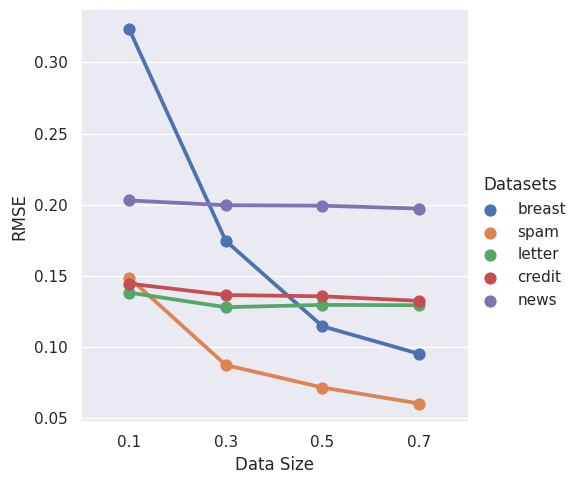

In [ ]:
data_sizes = [0.1, 0.3, 0.5, 0.7]
df = pd.DataFrame(list(zip(data_sizes, total_7[0], total_7[1], total_7[2], total_7[3], total_7[4])), 
               columns =['Data Size', 'breast', 'spam', 'letter', 'credit', 'news'])

df = df.melt('Data Size', var_name='Datasets', value_name='RMSE')
# g = sns.catplot(x='Data Size %', y="RMSE", hue='Datasets', data=df, kind='point')
sns.catplot(x='Data Size', y="RMSE", hue='Datasets', data=df, kind='point').savefig("plots/datasize.png")

### c) Alpha parameter (number of features):

In [ ]:
# Reset System Parameters
mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs = init_params()

In [ ]:
alpha_list = [0, 3, 5, 6, 8, 10, 15, 20]

total_8 = []
for dataset_file in dataset_file_list:
    total_avg_list_8 = []
    print('Dataset: {}'.format(str(dataset_file)))
    for a in alpha_list:
        total_avg, total_std = experiment(dataset_file, Lg=True, Lm=True, hint=True, 
                                          epochs=epochs, learning_rate=learning_rate, alpha=a, printLoss=False)
        total_avg_list_8.append(total_avg)
    total_8.append(total_avg_list_8)
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.4306396361107305
Standard Deviation of RMSE score: 0.05239012250889674


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.5248182135485694
Standard Deviation of RMSE score: 0.0810552021293223
Total average: 0.4777289248296499
Total std: 0.04708928871891946


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1168801279254924
Standard Deviation of RMSE score: 0.004587876197818051


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.11613124412280885
Standard Deviation of RMSE score: 0.0023140186889938352
Total average: 0.11650568602415062
Total std: 0.0003744419013417752


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1122468522916642
Standard Deviation of RMSE score: 0.003967891829186457


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.10916024542212673
Standard Deviation of RMSE score: 0.003456680513450383
Total average: 0.11070354885689546
Total std: 0.0015433034347687377


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09960193176205503
Standard Deviation of RMSE score: 0.0007356697863989056


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09895477905566985
Standard Deviation of RMSE score: 0.0025110236878018374
Total average: 0.09927835540886244
Total std: 0.00032357635319259226


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.10624372417048485
Standard Deviation of RMSE score: 0.0011450619043477522


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.10192557268357677
Standard Deviation of RMSE score: 0.0017676298069486465
Total average: 0.1040846484270308
Total std: 0.002159075743454038


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09590014035553701
Standard Deviation of RMSE score: 0.0007958304846300071


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09872544302144756
Standard Deviation of RMSE score: 0.003982222180736329
Total average: 0.09731279168849229
Total std: 0.0014126513329552753


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09169364995483631
Standard Deviation of RMSE score: 0.0016999820038351918


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09200270067176713
Standard Deviation of RMSE score: 0.00023166475142292337
Total average: 0.09184817531330172
Total std: 0.0001545253584654127


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09137409786425053
Standard Deviation of RMSE score: 0.0014969495558184442


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09538130521447742
Standard Deviation of RMSE score: 0.0022629325187193267
Total average: 0.09337770153936398
Total std: 0.002003603675113444
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.37461464469358297
Standard Deviation of RMSE score: 0.02184456753927974


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.14801570767663916
Standard Deviation of RMSE score: 0.08783012262373023
Total average: 0.2613151761851111
Total std: 0.1132994685084719


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.05862333697374497
Standard Deviation of RMSE score: 0.000835915509724082


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.05931296348747819
Standard Deviation of RMSE score: 0.0003339025401481073
Total average: 0.05896815023061158
Total std: 0.0003448132568666107


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.056054968555151956
Standard Deviation of RMSE score: 0.00011130540479235146


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.056154972574620626
Standard Deviation of RMSE score: 0.00021086410519691873
Total average: 0.056104970564886295
Total std: 5.0002009734335245e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.05403866254624776
Standard Deviation of RMSE score: 0.00020617590522805165


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.05423987879852234
Standard Deviation of RMSE score: 0.00010991871679634502
Total average: 0.05413927067238505
Total std: 0.00010060812613729014


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.05376314321039065
Standard Deviation of RMSE score: 0.001382118350417759


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.053485322353056475
Standard Deviation of RMSE score: 0.0005426453616704345
Total average: 0.05362423278172356
Total std: 0.00013891042866708697


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.053150061580087386
Standard Deviation of RMSE score: 0.0002556173051720331


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.05334816667809655
Standard Deviation of RMSE score: 0.00013397605459158218
Total average: 0.053249114129091966
Total std: 9.905254900458016e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.052081866553555525
Standard Deviation of RMSE score: 0.0006141112838412739


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.052731402632103824
Standard Deviation of RMSE score: 0.0004849078056597504
Total average: 0.052406634592829675
Total std: 0.0003247680392741495


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.05196475325254555
Standard Deviation of RMSE score: 0.0006229050189786242


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.052279638876383414
Standard Deviation of RMSE score: 0.0005447263736700868
Total average: 0.052122196064464485
Total std: 0.00015744281191893209
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.5023927419512756
Standard Deviation of RMSE score: 0.008328642990086288


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.5051036492774346
Standard Deviation of RMSE score: 0.06253889713136768
Total average: 0.503748195614355
Total std: 0.0013554536630794867


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13095097087810081
Standard Deviation of RMSE score: 0.0011377235278871023


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13160581680226585
Standard Deviation of RMSE score: 0.0017773392510768843
Total average: 0.13127839384018333
Total std: 0.00032742296208251864


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1328201751242994
Standard Deviation of RMSE score: 0.0006102707154386766


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.128704507794346
Standard Deviation of RMSE score: 0.0021664033096022856
Total average: 0.1307623414593227
Total std: 0.0020578336649766937


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13421805701298603
Standard Deviation of RMSE score: 0.0007072276802670696


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1280063930020946
Standard Deviation of RMSE score: 9.463729197582704e-05
Total average: 0.13111222500754033
Total std: 0.003105832005445716


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1337185156252133
Standard Deviation of RMSE score: 0.004810025954987321


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1309764106566515
Standard Deviation of RMSE score: 0.0014245935476649152
Total average: 0.1323474631409324
Total std: 0.0013710524842809046


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.12892978783822273
Standard Deviation of RMSE score: 0.0002687714835905436


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1335056957809086
Standard Deviation of RMSE score: 0.0036885671782719426
Total average: 0.13121774180956566
Total std: 0.002287953971342932


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.130342672098679
Standard Deviation of RMSE score: 0.001437354101948382


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13191980460985492
Standard Deviation of RMSE score: 0.0001443297977263419
Total average: 0.13113123835426696
Total std: 0.000788566255587958


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.12855379413538803
Standard Deviation of RMSE score: 0.0020731476269116172


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13181595921380815
Standard Deviation of RMSE score: 0.0010415101367600432
Total average: 0.1301848766745981
Total std: 0.0016310825392100575
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.40895774589392453
Standard Deviation of RMSE score: 0.1619197548898319


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.36256363794914315
Standard Deviation of RMSE score: 0.05211395697193563
Total average: 0.38576069192153384
Total std: 0.02319705397239069


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.14959627260048736
Standard Deviation of RMSE score: 0.009497619597516063


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1386684610011083
Standard Deviation of RMSE score: 0.0026470654681651218
Total average: 0.14413236680079783
Total std: 0.005463905799689528


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13687251428393402
Standard Deviation of RMSE score: 0.0017317811250263937


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13659069700225518
Standard Deviation of RMSE score: 0.0002045299122405142
Total average: 0.1367316056430946
Total std: 0.00014090864083941834


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1355548562279509
Standard Deviation of RMSE score: 0.0011259118224794251


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.14024639005431244
Standard Deviation of RMSE score: 0.0007415577104482735
Total average: 0.13790062314113166
Total std: 0.0023457669131807662


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1350279759815364
Standard Deviation of RMSE score: 0.0015569625245173968


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13412327982969763
Standard Deviation of RMSE score: 0.0014581973135377457
Total average: 0.134575627905617
Total std: 0.0004523480759193871


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1357925380144553
Standard Deviation of RMSE score: 0.0031604330219099364


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1360425831163199
Standard Deviation of RMSE score: 0.0007741762854265727
Total average: 0.1359175605653876
Total std: 0.0001250225509323022


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13399533353903942
Standard Deviation of RMSE score: 0.00011262097671024818


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1370186792556406
Standard Deviation of RMSE score: 0.0034914023929250443
Total average: 0.13550700639734
Total std: 0.001511672858300589


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13355417029839112
Standard Deviation of RMSE score: 0.0011675094112302692


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13314955353008984
Standard Deviation of RMSE score: 0.0008577988801132669
Total average: 0.13335186191424048
Total std: 0.00020230838415064012
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.4762310827601321
Standard Deviation of RMSE score: 0.08458764644563305


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.4909685542920158
Standard Deviation of RMSE score: 0.034907348362330254
Total average: 0.4835998185260739
Total std: 0.007368735765941853


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.20042084623998596
Standard Deviation of RMSE score: 0.0024760241326716864


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.20028884899357033
Standard Deviation of RMSE score: 0.0001211344741018916
Total average: 0.20035484761677813
Total std: 6.599862320781635e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19364344807216097
Standard Deviation of RMSE score: 0.0017035146771703646


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19475488998002283
Standard Deviation of RMSE score: 0.002735494711685868
Total average: 0.1941991690260919
Total std: 0.0005557209539309299


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19633088753728417
Standard Deviation of RMSE score: 0.00034217280896252367


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1981958469013259
Standard Deviation of RMSE score: 0.0015343696468229778
Total average: 0.19726336721930504
Total std: 0.0009324796820208703


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.20238985079771776
Standard Deviation of RMSE score: 0.005759612460581376


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19877530166865823
Standard Deviation of RMSE score: 0.003882392234701132
Total average: 0.20058257623318798
Total std: 0.0018072745645297678


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19547170653941603
Standard Deviation of RMSE score: 0.0015894712691305463


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19728738000304286
Standard Deviation of RMSE score: 0.0018944350677199823
Total average: 0.19637954327122945
Total std: 0.0009078367318134106


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1970716251995071
Standard Deviation of RMSE score: 0.00020402728943431925


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19883979544237507
Standard Deviation of RMSE score: 0.004952295555234618
Total average: 0.1979557103209411
Total std: 0.0008840851214339807


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.2027423691713543
Standard Deviation of RMSE score: 0.002001934272221159


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.199883393558817
Standard Deviation of RMSE score: 0.002747010160199362
Total average: 0.20131288136508566
Total std: 0.0014294878062686422
-------------------------------------



In [ ]:
print("breast | spam | letter | credit | news")
print(total_8)

breast | spam | letter | credit | news
[[0.4777289248296499, 0.11650568602415062, 0.11070354885689546, 0.09927835540886244, 0.1040846484270308, 0.09731279168849229, 0.09184817531330172, 0.09337770153936398], [0.2613151761851111, 0.05896815023061158, 0.056104970564886295, 0.05413927067238505, 0.05362423278172356, 0.053249114129091966, 0.052406634592829675, 0.052122196064464485], [0.503748195614355, 0.13127839384018333, 0.1307623414593227, 0.13111222500754033, 0.1323474631409324, 0.13121774180956566, 0.13113123835426696, 0.1301848766745981], [0.38576069192153384, 0.14413236680079783, 0.1367316056430946, 0.13790062314113166, 0.134575627905617, 0.1359175605653876, 0.13550700639734, 0.13335186191424048], [0.4835998185260739, 0.20035484761677813, 0.1941991690260919, 0.19726336721930504, 0.20058257623318798, 0.19637954327122945, 0.1979557103209411, 0.20131288136508566]]


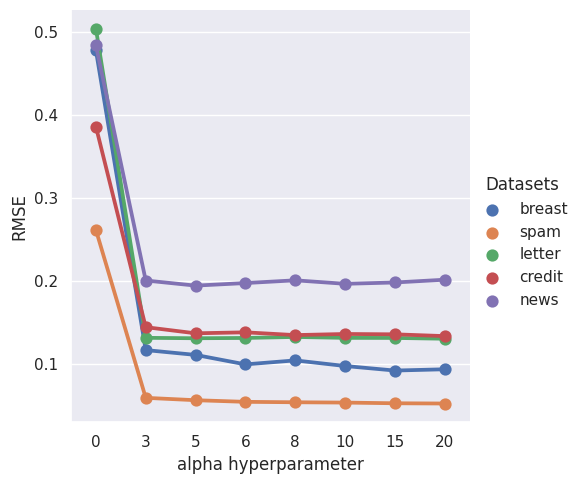

In [ ]:
df = pd.DataFrame(list(zip(alpha_list, total_8[0], total_8[1], 
                           total_8[2], total_8[3], total_8[4])), 
                  columns =['alpha hyperparameter', 'breast', 'spam', 'letter', 'credit', 'news'])

df = df.melt('alpha hyperparameter', var_name='Datasets', value_name='RMSE')
# g = sns.catplot(x='alpha hyperparameter', y="RMSE", hue='Datasets', data=df, kind='point')
sns.catplot(x='alpha hyperparameter', y="RMSE", hue='Datasets', data=df, kind='point').savefig("plots/alpha.png")

### d) Learning rate:

In [ ]:
# Reset System Parameters
mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs = init_params()

In [ ]:
learning_rate_list = [0.1, 0.01, 0.001]

total_9 = []
for dataset_file in dataset_file_list:
    total_avg_list_9 = []
    print('Dataset: {}'.format(str(dataset_file)))
    for lr in learning_rate_list:
        total_avg, total_std = experiment(dataset_file, Lg=True, Lm=True, hint=True, 
                                          epochs=epochs, learning_rate=lr, printLoss=False)
        total_avg_list_9.append(total_avg)
    total_9.append(total_avg_list_9)
    print("-------------------------------------")
    print()

Dataset: unlabeled-data/breast.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.22893391895857362
Standard Deviation of RMSE score: 0.1130628422261139


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.2157977196066642
Standard Deviation of RMSE score: 0.11832891776428169
Total average: 0.2223658192826189
Total std: 0.006568099675954717


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.10311744874258513
Standard Deviation of RMSE score: 0.0008605170173971166


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.10913159517565314
Standard Deviation of RMSE score: 0.0024970502847472126
Total average: 0.10612452195911914
Total std: 0.003007073216534005


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09717974813522023
Standard Deviation of RMSE score: 0.0036013181529319996


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.09124628679581336
Standard Deviation of RMSE score: 0.002556056305300175
Total average: 0.0942130174655168
Total std: 0.0029667306697034393
-------------------------------------

Dataset: unlabeled-data/Spam.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06025215710005451
Standard Deviation of RMSE score: 6.62780384442993e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06025215710005451
Standard Deviation of RMSE score: 6.62780384442993e-05
Total average: 0.06025215710005451
Total std: 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06025215710005451
Standard Deviation of RMSE score: 6.62780384442993e-05


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.06025215710005451
Standard Deviation of RMSE score: 6.62780384442993e-05
Total average: 0.06025215710005451
Total std: 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.053270855069559586
Standard Deviation of RMSE score: 0.00041438993473339944


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.053369935716470154
Standard Deviation of RMSE score: 0.00011340637211177187
Total average: 0.05332039539301487
Total std: 4.9540323455284085e-05
-------------------------------------

Dataset: unlabeled-data/Letter.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13667085986350558
Standard Deviation of RMSE score: 0.0017464863041086187


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.13842650305316304
Standard Deviation of RMSE score: 0.0006202167598587938
Total average: 0.13754868145833432
Total std: 0.0008778215948287288


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.12503079882040435
Standard Deviation of RMSE score: 0.0008007512924782384


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.129382572012548
Standard Deviation of RMSE score: 0.0009563214302141659
Total average: 0.12720668541647617
Total std: 0.0021758865960718188


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.12821327841760405
Standard Deviation of RMSE score: 0.0009354464214767905


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1277140142174678
Standard Deviation of RMSE score: 1.6987297367945797e-05
Total average: 0.12796364631753593
Total std: 0.0002496321000681201
-------------------------------------

Dataset: unlabeled-data/credit.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.17381056649685467
Standard Deviation of RMSE score: 0.014074134525926527


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.23169263405100476
Standard Deviation of RMSE score: 0.05147143364822393
Total average: 0.20275160027392972
Total std: 0.028941033777075048


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.14604892114038298
Standard Deviation of RMSE score: 0.008987638507792592


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1420301972323605
Standard Deviation of RMSE score: 0.0006908419694064416
Total average: 0.14403955918637174
Total std: 0.002009361954011246


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1337908157908711
Standard Deviation of RMSE score: 0.0012594774965346556


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.1341128499702436
Standard Deviation of RMSE score: 5.3815009475849385e-05
Total average: 0.13395183288055734
Total std: 0.00016101708968625783
-------------------------------------

Dataset: unlabeled-data/OnlineNewsPopularity.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.32265118104419876
Standard Deviation of RMSE score: 0.002356859522918836


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.32847714611582635
Standard Deviation of RMSE score: 0.004264773157403895
Total average: 0.32556416358001256
Total std: 0.0029129825358137906


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.21686926795453196
Standard Deviation of RMSE score: 0.0015894204741636053


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.2223042592753504
Standard Deviation of RMSE score: 0.002503848169190498
Total average: 0.21958676361494117
Total std: 0.0027174956604092276


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19188847356953975
Standard Deviation of RMSE score: 0.00034563413109141294


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Average RMSE score: 0.19542683494287072
Standard Deviation of RMSE score: 0.0003667353500888676
Total average: 0.19365765425620524
Total std: 0.0017691806866654836
-------------------------------------



In [ ]:
print("breast | spam | letter | credit | news")
print(total_9)

breast | spam | letter | credit | news
[[0.2223658192826189, 0.10612452195911914, 0.0942130174655168], [0.06025215710005451, 0.06025215710005451, 0.05332039539301487], [0.13754868145833432, 0.12720668541647617, 0.12796364631753593], [0.20275160027392972, 0.14403955918637174, 0.13395183288055734], [0.32556416358001256, 0.21958676361494117, 0.19365765425620524]]


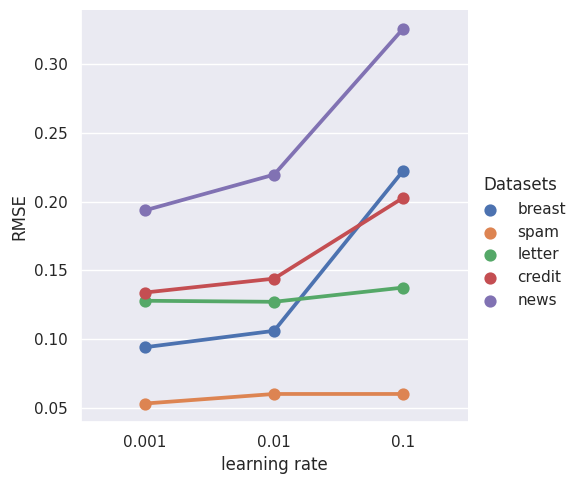

In [ ]:
df = pd.DataFrame(list(zip(learning_rate_list, total_9[0], total_9[1], 
                           total_9[2], total_9[3], total_9[4])), 
                  columns =['learning rate', 'breast', 'spam', 'letter', 'credit', 'news'])

df = df.melt('learning rate', var_name='Datasets', value_name='RMSE')
# g = sns.catplot(x='learning rate', y="RMSE", hue='Datasets', data=df, kind='point')
sns.catplot(x='learning rate', y="RMSE", hue='Datasets', data=df, kind='point').savefig("plots/lrates.png")

#### 4. Prediction quality post-imputations

### Datasets (with labels)

In [ ]:
#%% Data (with labels)
dataset_file_list_labels = ['labeled-data/breast_with_label.csv', 'labeled-data/Spam_with_label.csv', 
                            'labeled-data/credit_with_label.csv', 
                            'labeled-data/OnlineNewsPopularity_with_label.csv']

In [ ]:
le = preprocessing.LabelEncoder()

#### Plotting missing data over auroc score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

In [ ]:
# Reset System Parameters
mb_size, p_miss, p_hint, alpha, train_rate, learning_rate, epochs = init_params()

In [ ]:
missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
auroc_mean_list = []

for dataset_file in dataset_file_list_labels:
    print('Dataset: {}'.format(str(dataset_file)))
    auroc_mean = []
    for mr in missing_rates:
        # Missing rate
        p_miss = mr
        auroc_mean.append(experiment(dataset_file, Lg=True, Lm=True, hint=True, 
                                     epochs=epochs, learning_rate=learning_rate, impute=True, printLoss=False)) 
    auroc_mean_list.append(auroc_mean)
    print("-------------------------------------")
    print()

auroc_mean_ = np.array(auroc_mean_list)
auroc_mean_ = auroc_mean_.transpose(2, 0, 1).reshape(-1, auroc_mean_.shape[1])

Dataset: labeled-data/breast_with_label.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

-------------------------------------

Dataset: labeled-data/Spam_with_label.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

-------------------------------------

Dataset: labeled-data/credit_with_label.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

-------------------------------------

Dataset: labeled-data/OnlineNewsPopularity_with_label.csv


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

-------------------------------------



In [ ]:
print("breast | spam | credit | news")
print(auroc_mean_)

In [ ]:
df = pd.DataFrame(list(zip(missing_rates, list(auroc_mean_[0]), list(auroc_mean_[1]), 
                           list(auroc_mean_[2]) ,list(auroc_mean_[3]))), 
                  columns =['Missing Rate', 'breast', 'spam', 'credit', 'news'])

df = df.melt('Missing Rate', var_name='Datasets', value_name='AUC score')
# g = sns.catplot(x='Missing Rate %', y="AUC score", hue='Datasets', data=df, kind='point')
sns.catplot(x='Missing Rate', y="AUC score", hue='Datasets', data=df, kind='point').savefig("plots/auroc.png")